# Conditional Autoencoder for Asset Pricing - Part 1: The Data

In [127]:
from pathlib import Path

import numpy as np
import pandas as pd

from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
idx = pd.IndexSlice
sns.set_style('whitegrid')

In [128]:
results_path = Path('KR2_results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Load Data

### Prices

In [129]:
prices = pd.read_hdf(results_path / 'data.h5', 'stocks/prices/adjusted')

In [130]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3817016 entries, ('000020.KS', Timestamp('2000-01-04 00:00:00')) to ('950210.KS', Timestamp('2023-05-08 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   close   3817016 non-null  float64
 1   high    3817016 non-null  float64
 2   low     3817016 non-null  float64
 3   open    3817016 non-null  float64
 4   volume  3817016 non-null  float64
dtypes: float64(5)
memory usage: 160.4+ MB


In [131]:
prices.index

MultiIndex([('000020.KS', '2000-01-04'),
            ('000020.KS', '2000-01-05'),
            ('000020.KS', '2000-01-06'),
            ('000020.KS', '2000-01-07'),
            ('000020.KS', '2000-01-10'),
            ('000020.KS', '2000-01-11'),
            ('000020.KS', '2000-01-12'),
            ('000020.KS', '2000-01-13'),
            ('000020.KS', '2000-01-14'),
            ('000020.KS', '2000-01-17'),
            ...
            ('950210.KS', '2023-04-21'),
            ('950210.KS', '2023-04-24'),
            ('950210.KS', '2023-04-25'),
            ('950210.KS', '2023-04-26'),
            ('950210.KS', '2023-04-27'),
            ('950210.KS', '2023-04-28'),
            ('950210.KS', '2023-05-02'),
            ('950210.KS', '2023-05-03'),
            ('950210.KS', '2023-05-04'),
            ('950210.KS', '2023-05-08')],
           names=['ticker', 'date'], length=3817016)

### Metadata

In [132]:
metadata = pd.read_hdf(results_path / 'data.h5', 'stocks/info').rename(columns=str.lower)

In [133]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 960 entries, 005930.KS to 000547.KS
Columns: 117 entries, address1 to fulltimeemployees
dtypes: float64(89), int64(1), object(27)
memory usage: 885.0+ KB


In [134]:
metadata

,address1,address2,city,zip,country,phone,fax,website,industry,industrydisp,...,operatingcashflow,earningsgrowth,revenuegrowth,grossmargins,ebitdamargins,operatingmargins,financialcurrency,trailingpegratio,openinterest,fulltimeemployees
005930.KS,129 Samsung-Ro,Maetan-3dong Yeongtong-gu,Suwon-si,443-742,South Korea,82 2 2255 0114,82 3 1200 7538,https://www.samsung.com,Consumer Electronics,Consumer Electronics,...,5.802135e+13,-0.874,-0.180,0.34427,0.23870,0.10374,KRW,NaN,NaN,NaN
373220.KS,"108, Yeoui-daero",Yeongdeungpo-Gu,Seoul,07335,South Korea,82 2 3777 1114,NaN,https://www.lgensol.com,Specialty Industrial Machinery,Specialty Industrial Machinery,...,-5.798070e+11,4.290,0.923,0.16761,0.11458,0.04741,KRW,NaN,NaN,NaN
000660.KS,2091 Gyeongchung-daero,Bubal-eup,Icheon-Si,NaN,South Korea,82 31 5185 4114,NaN,https://www.skhynix.com,Semiconductors,Semiconductors,...,1.478052e+13,NaN,-0.380,0.35023,0.45662,0.15260,KRW,NaN,NaN,NaN
207940.KS,"300, Songdo Bio-daero",Yeonsu-gu,Incheon,21987,South Korea,82 3 2455 3114,NaN,https://samsungbiologics.com,Biotechnology,Biotechnology,...,9.530478e+11,3.334,1.173,0.48671,0.43044,0.32773,KRW,NaN,0.0,NaN
051910.KS,LG Twin Towers,"128, Yeoui-daero Yeongdeungpo-gu",Seoul,NaN,South Korea,82 2 3773 1114,NaN,https://www.lgchem.com,Chemicals,Chemicals,...,5.698800e+11,-0.707,0.267,0.19255,0.12324,0.05776,KRW,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000545.KS,68 Saemunan-ro,Jongno-gu,Seoul,03184,South Korea,82 2 6260 7995,NaN,https://www.heungkukfire.co.kr,Insurance—Property & Casualty,NaN,...,9.945840e+11,3.632,0.120,0.18593,0.09007,0.08493,KRW,NaN,NaN,NaN
001527.KS,Samsung Life Yeouido Building,3-4th Floor 24 Gukjegeumyungro 2-gil Yeongdeun...,Seoul,NaN,South Korea,82 2 6150 7000,82 2 6150 7109,https://www.tongyanginc.co.kr,Building Materials,Building Materials,...,-2.714819e+10,NaN,NaN,0.10610,0.02875,0.01032,KRW,NaN,NaN,NaN
001525.KS,Samsung Life Yeouido Building,3-4th Floor 24 Gukjegeumyungro 2-gil Yeongdeun...,Seoul,NaN,South Korea,82 2 6150 7000,82 2 6150 7109,https://www.tongyanginc.co.kr,Building Materials,Building Materials,...,-2.714819e+10,NaN,NaN,0.10610,0.02875,0.01032,KRW,NaN,NaN,NaN
002787.KS,"69, Convensia-daero",Yeonsu-gu,Incheon,NaN,South Korea,82 2 772 1200,82 2 776 9678,https://www.chinhung.co.kr,Engineering & Construction,Engineering & Construction,...,2.054867e+10,0.478,0.359,0.09571,0.06813,0.06748,KRW,NaN,NaN,NaN


### Select tickers with metadata

In [135]:
sectors = (metadata.sector.value_counts() > 50).index

In [136]:
sectors

Index(['Industrials', 'Consumer Cyclical', 'Basic Materials', 'Technology',
       'Consumer Defensive', 'Healthcare', 'Financial Services',
       'Communication Services', 'Real Estate', 'Utilities', 'Energy'],
      dtype='object')

In [137]:
tickers_with_errors = []

In [138]:
tickers_with_metadata = metadata[metadata.sector.isin(sectors) & 
                                 metadata.marketcap.notnull() &
                                 metadata.sharesoutstanding.notnull() & 
                                (metadata.sharesoutstanding > 0)].index.drop(tickers_with_errors)

In [139]:
tickers_with_metadata

Index(['005930.KS', '373220.KS', '000660.KS', '207940.KS', '051910.KS',
       '006400.KS', '005935.KS', '005380.KS', '000270.KS', '035420.KS',
       ...
       '011155.KS', '004415.KS', '014915.KS', '000227.KS', '002785.KS',
       '000545.KS', '001527.KS', '001525.KS', '002787.KS', '000547.KS'],
      dtype='object', length=926)

In [140]:
metadata = metadata.loc[tickers_with_metadata, ['sector', 'sharesoutstanding', 'marketcap']]
metadata.index.name = 'ticker'

In [142]:
prices = prices.loc[idx[tickers_with_metadata, :], :]

C:\Users\chldl\AppData\Local\Temp\ipykernel_953484\626631212.py:1: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  prices = prices.loc[idx[tickers_with_metadata, :], :]


In [143]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3768223 entries, ('005930.KS', Timestamp('2000-01-04 00:00:00')) to ('000547.KS', Timestamp('2023-05-08 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   close   3768223 non-null  float64
 1   high    3768223 non-null  float64
 2   low     3768223 non-null  float64
 3   open    3768223 non-null  float64
 4   volume  3768223 non-null  float64
dtypes: float64(5)
memory usage: 158.3+ MB


In [145]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 926 entries, 005930.KS to 000547.KS
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sector             926 non-null    object 
 1   sharesoutstanding  926 non-null    float64
 2   marketcap          926 non-null    float64
dtypes: float64(2), object(1)
memory usage: 28.9+ KB


In [146]:
close = prices.close.unstack('ticker').sort_index()
close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5858 entries, 2000-01-04 to 2023-05-08
Columns: 858 entries, 005930.KS to 000547.KS
dtypes: float64(858)
memory usage: 38.4 MB


In [147]:
volume = prices.volume.unstack('ticker').sort_index()
volume.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5858 entries, 2000-01-04 to 2023-05-08
Columns: 858 entries, 005930.KS to 000547.KS
dtypes: float64(858)
memory usage: 38.4 MB


### Create weekly returns

In [148]:
returns = (prices.close
           .unstack('ticker')
           .resample('W-FRI').last()
           .sort_index().pct_change().iloc[1:])
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1218 entries, 2000-01-14 to 2023-05-12
Freq: W-FRI
Columns: 858 entries, 005930.KS to 000547.KS
dtypes: float64(858)
memory usage: 8.0 MB


In [149]:
dates = returns.index

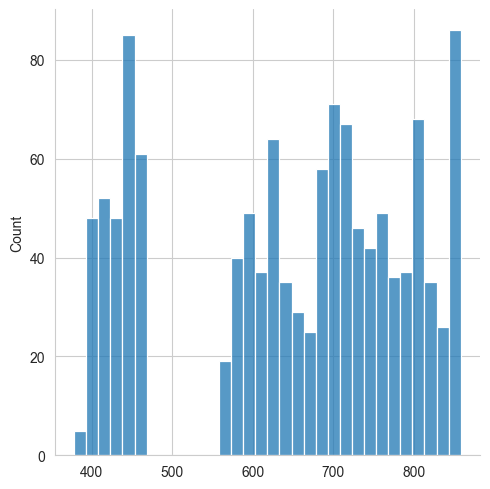

In [152]:
sns.displot(returns.count(1), kde=False, binwidth=15);

In [153]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    store.put('close', close)
    store.put('volume', volume)
    store.put('returns', returns)
    store.put('metadata', metadata)

## Factor Engineering

In [154]:
MONTH = 21

### Price Trend

#### Short-Term Reversal

1-month cumulative return

In [155]:
dates[:5]

DatetimeIndex(['2000-01-14', '2000-01-21', '2000-01-28', '2000-02-04',
               '2000-02-11'],
              dtype='datetime64[ns]', name='date', freq='W-FRI')

In [156]:
mom1m = close.pct_change(periods=MONTH).resample('W-FRI').last().stack().to_frame('mom1m')
mom1m.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 784469 entries, (Timestamp('2000-02-04 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2023-05-12 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mom1m   784469 non-null  float64
dtypes: float64(1)
memory usage: 9.1+ MB


In [157]:
mom1m.squeeze().to_hdf(results_path / 'autoencoder.h5', 'factor/mom1m')

#### Stock Momentum

11-month cumulative returns ending 1-month before month end

In [158]:
mom12m = (close
            .pct_change(periods=11 * MONTH)
            .shift(MONTH)
            .resample('W-FRI')
            .last()
            .stack()
            .to_frame('mom12m'))

In [159]:
mom12m.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 744340 entries, (Timestamp('2000-12-22 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2023-05-12 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mom12m  744340 non-null  float64
dtypes: float64(1)
memory usage: 8.6+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_953484\734250054.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  mom12m.info(null_counts=True)


In [160]:
mom12m.to_hdf(results_path / 'autoencoder.h5', 'factor/mom12m')

#### Momentum Change

Cumulative return from months t-6 to t-1 minus months t-12 to t-7.

In [161]:
chmom = (close
         .pct_change(periods=6 * MONTH)
         .sub(close.pct_change(periods=6 * MONTH).shift(6 * MONTH))
         .resample('W-FRI')
         .last()
         .stack()
         .to_frame('chmom'))

In [162]:
chmom.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 744340 entries, (Timestamp('2000-12-22 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2023-05-12 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   chmom   744340 non-null  float64
dtypes: float64(1)
memory usage: 8.6+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_953484\480465195.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  chmom.info(null_counts=True)


In [163]:
chmom.to_hdf(results_path / 'autoencoder.h5', 'factor/chmom')

#### Industry Momentum

Equal-weighted avg. industry 12-month returns

In [164]:
indmom = (close.pct_change(12*MONTH)
          .resample('W-FRI')
          .last()
          .stack()
          .to_frame('close')
          .join(metadata[['sector']]).groupby(['date', 'sector'])
          .close.mean()
          .to_frame('indmom')
          .reset_index())

In [165]:
indmom.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12848 entries, 0 to 12847
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    12848 non-null  datetime64[ns]
 1   sector  12848 non-null  object        
 2   indmom  12848 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 301.2+ KB


C:\Users\chldl\AppData\Local\Temp\ipykernel_953484\949876339.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  indmom.info(null_counts=True)


In [166]:
indmom = (returns
          .stack()
          .to_frame('ret')
          .join(metadata[['sector']])
          .reset_index()
          .merge(indmom)
          .set_index(['date', 'ticker'])
          .loc[:, ['indmom']])

In [167]:
indmom.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 767616 entries, (Timestamp('2000-12-22 00:00:00'), '005930.KS') to (Timestamp('2023-05-12 00:00:00'), '140910.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   indmom  767616 non-null  float64
dtypes: float64(1)
memory usage: 8.9+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_953484\949876339.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  indmom.info(null_counts=True)


In [168]:
indmom.to_hdf(results_path / 'autoencoder.h5', 'factor/indmom')

#### Recent Max Return

Max daily returns from calendar month t-1

In [169]:
maxret = (close
           .pct_change(periods=MONTH)
           .rolling(21)
           .max()
           .resample('W-FRI')
           .last()
           .stack()
           .to_frame('maxret'))

In [170]:
maxret.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 780979 entries, (Timestamp('2000-03-03 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2023-05-12 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   maxret  780979 non-null  float64
dtypes: float64(1)
memory usage: 9.0+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_953484\180646522.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  maxret.info(null_counts=True)


In [171]:
maxret.to_hdf(results_path / 'autoencoder.h5', 'factor/maxret')

#### Long-Term Reversal

Cumulative returns months t-36 to t-13.

In [172]:
mom36m = (close
           .pct_change(periods=24*MONTH)
           .shift(12*MONTH)
           .resample('W-FRI')
           .last()
           .stack()
           .to_frame('mom36m'))

In [173]:
mom36m.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 658553 entries, (Timestamp('2002-11-29 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2023-05-12 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mom36m  658553 non-null  float64
dtypes: float64(1)
memory usage: 7.6+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_953484\3570578006.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  mom36m.info(null_counts=True)


In [174]:
mom36m.to_hdf(results_path / 'autoencoder.h5', 'factor/mom36m')

### Liquidity Metrics

#### Turnover

Avg. monthly trading volume for most recent three months scaled by number of shares; we are using the most recent no of shares from yahoo finance

In [175]:
turn = (volume
        .rolling(3*MONTH)
        .mean()
        .resample('W-FRI')
        .last()
        .div(metadata.sharesoutstanding)
        .stack('ticker')
        .to_frame('turn'))

In [176]:
turn.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 771259 entries, (Timestamp('2000-03-31 00:00:00', freq='W-FRI'), '000020.KS') to (Timestamp('2023-05-12 00:00:00', freq='W-FRI'), '950210.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   turn    771259 non-null  float64
dtypes: float64(1)
memory usage: 8.9+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_953484\2727825691.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  turn.info(null_counts=True)


In [177]:
turn.to_hdf(results_path / 'autoencoder.h5', 'factor/turn')

#### Turnover Volatility

Monthly std dev of daily share turnover

In [178]:
turn_std = (prices
            .volume
            .unstack('ticker')
            .div(metadata.sharesoutstanding)
            .rolling(MONTH)
            .std()
            .resample('W-FRI')
            .last()
            .stack('ticker')
            .to_frame('turn_std'))

In [179]:
turn_std.to_hdf(results_path / 'autoencoder.h5', 'factor/turn_std')

#### Log Market Equity

Natural log of market cap at end of month t-1

In [180]:
last_price = close.ffill()
factor = close.div(last_price.iloc[-1])
mvel = np.log1p(factor.mul(metadata.marketcap).resample('W-FRI').last()).stack().to_frame('mvel')

In [181]:
mvel.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 788034 entries, (Timestamp('2000-01-07 00:00:00', freq='W-FRI'), '000020.KS') to (Timestamp('2023-05-12 00:00:00', freq='W-FRI'), '950210.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mvel    788034 non-null  float64
dtypes: float64(1)
memory usage: 9.1+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_953484\567849824.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  mvel.info(null_counts=True)


In [182]:
mvel.to_hdf(results_path / 'autoencoder.h5', 'factor/mvel')

#### Dollar Volume

Natural log of trading volume time price per share from month t-2

In [183]:
dv = close.mul(volume)

In [184]:
dolvol = (np.log1p(dv.rolling(21)
                  .mean()
                  .shift(21)
                  .resample('W-FRI')
                  .last())
          .stack()
          .to_frame('dolvol'))

In [185]:
dolvol.to_hdf(results_path / 'autoencoder.h5', 'factor/dolvol')

#### Amihud Illiquidity

Average of daily (absolute return / dollar volume)

In [186]:
ill = (close.pct_change().abs()
       .div(dv)
       .rolling(21)
       .mean()
       .resample('W-FRI').last()
       .stack()
       .to_frame('ill'))

In [187]:
ill.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 628189 entries, (Timestamp('2000-02-04 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2023-05-12 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ill     628189 non-null  float64
dtypes: float64(1)
memory usage: 7.3+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_953484\1107602282.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  ill.info(null_counts=True)


In [188]:
ill.to_hdf(results_path / 'autoencoder.h5', 'factor/ill')

### Risk Measures

#### Return Volatility

Standard dev of daily returns from month t-1.

In [189]:
retvol = (close.pct_change()
          .rolling(21)
          .std()
          .resample('W-FRI')
          .last()
          .stack()
          .to_frame('retvol'))

In [190]:
retvol.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 784469 entries, (Timestamp('2000-02-04 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2023-05-12 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   retvol  784469 non-null  float64
dtypes: float64(1)
memory usage: 9.1+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_953484\2042333437.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  retvol.info(null_counts=True)


In [191]:
retvol.to_hdf(results_path / 'autoencoder.h5', 'factor/retvol')

#### Market Beta

Estimated market beta from weekly returns and equal weighted market returns for 3 years ending month t-1 with at least 52 weeks of returns.

In [192]:
index = close.resample('W-FRI').last().pct_change().mean(1).to_frame('x')

In [193]:
def get_market_beta(y, x=index):
    df = x.join(y.to_frame('y')).dropna()
    model = RollingOLS(endog=df.y, 
                       exog=sm.add_constant(df[['x']]),
                      window=3*52)

    return model.fit(params_only=True).params['x']

In [194]:
# 20초
beta = (returns.dropna(thresh=3*52, axis=1)
        .apply(get_market_beta).stack().to_frame('beta'))

In [195]:
beta.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 658062 entries, (Timestamp('2003-01-03 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2023-05-12 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   beta    658062 non-null  float64
dtypes: float64(1)
memory usage: 7.6+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_953484\2943542198.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  beta.info(null_counts=True)


In [196]:
beta.to_hdf(results_path / 'autoencoder.h5', 'factor/beta')

#### Beta Squared

Market beta squared

In [197]:
betasq = beta.beta.pow(2).to_frame('betasq')

In [198]:
betasq.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 658062 entries, (Timestamp('2003-01-03 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2023-05-12 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   betasq  658062 non-null  float64
dtypes: float64(1)
memory usage: 7.6+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_953484\1828334906.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  betasq.info(null_counts=True)


In [199]:
betasq.to_hdf(results_path / 'autoencoder.h5', 'factor/betasq')

#### Idiosyncratic return volatility

Standard dev of a regression of residuals of weekly returns on the returns of an equal weighted market index returns for the prior three years.

This takes a while!

In [200]:
def get_ols_residuals(y, x=index):
    df = x.join(y.to_frame('y')).dropna()
    model = sm.OLS(endog=df.y, exog=sm.add_constant(df[['x']]))
    result = model.fit()
    return result.resid.std()

# 오래 걸림
idiovol = (returns.apply(lambda x: x.rolling(3 * 52)
                         .apply(get_ols_residuals)))

In [201]:
idiovol = idiovol.stack().to_frame('idiovol')

In [202]:
idiovol.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 658062 entries, (Timestamp('2003-01-03 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2023-05-12 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   idiovol  658062 non-null  float64
dtypes: float64(1)
memory usage: 7.6+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_953484\1780519557.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  idiovol.info(null_counts=True)


In [203]:
idiovol.to_hdf(results_path / 'autoencoder.h5', 'factor/idiovol')